In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/a/antonio-costa/BehaviorModel/utils')
import operator_calculations as op_calc
import worm_dynamics as worm_dyn
import stats
import h5py
import delay_embedding as embed
import operator_calculations as op_calc
import clustering_methods as cl

In [2]:
f = h5py.File('/bucket/StephensU/antonio/npr-1_data/resampled_results.h5','r')
print(list(f.keys()))
frameRate = np.array(f['new_frameRate'])[0]
worm_labels = list(f.keys())[1:]
tseries_w=[]
for worm in worm_labels:
    ts = ma.masked_invalid(np.array(f[worm]))
    tseries_w.append(ts)
f.close()


masked_ts_w = []
for worm in np.arange(len(tseries_w)):
    ts_w = tseries_w[worm]
    ts_w[0] = ma.masked
    ts_w[-1] = ma.masked
    masked_ts_w.append(ts_w)

segments=op_calc.segment_maskedArray(ma.vstack(masked_ts_w),5)
omegas_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
a3s_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
for t0,tf in segments:
    phi,omega,a3=worm_dyn.compute_phi_omega_a3(ma.vstack(masked_ts_w),t0,tf,frameRate=frameRate)
    omegas_all[t0:tf] = omega
    a3s_all[t0:tf] = a3
omegas_all[omegas_all==0]=ma.masked
a3s_all[a3s_all==0]=ma.masked

eigenworms_matrix = np.loadtxt('/bucket/StephensU/antonio/ForagingN2_data/EigenWorms.csv', delimiter=',').astype(np.float32)
thetas_w = ma.array([ts.dot(eigenworms_matrix[:,:5].T) for ts in masked_ts_w])
thetas_all = ma.vstack(thetas_w)
thetas_sum = thetas_all.sum(axis=1)

['new_frameRate', 'npr-1 (ad609) on food R_2010_01_26__12_44_18___2___7', 'npr-1 (ad609)X on food  R_2010_01_25__16_08___3___10', 'npr-1 (ad609)X on food L_2010_01_22__11_33_10___2___5', 'npr-1 (ad609)X on food L_2010_01_26__12_44___3___7', 'npr-1 (ad609)X on food R_2010_01_22__11_34_25___8___5', 'npr-1 (ad609)X on food R_2010_01_22__11_35_12__5', 'npr-1 (ad609)X on food R_2010_01_26__12_44_50___4___7']


In [3]:
dt= 1/frameRate

In [6]:
n_clusters=562

kw=0
f = h5py.File('/flash/StephensU/antonio/npr-1/tscales_noise_floor/results_{}.h5'.format(kw),'r')
delay_range = np.array(f['delay_range'])
n_clusters = np.array(f['n_clusters'],dtype=int)[0]
f.close()
n_modes=50
n_worms=7
n_shuffle=100

ts_traj_shuffle = np.zeros((n_worms,len(delay_range),n_shuffle))
eigvals_traj_shuffle = np.zeros((n_worms,len(delay_range),n_shuffle))
ts_traj_w = np.zeros((n_worms,len(delay_range),n_modes))
eigvals_traj_w = np.zeros((n_worms,len(delay_range),n_modes))
for kw in range(n_worms):
    f = h5py.File('/flash/StephensU/antonio/npr-1/tscales_noise_floor/results_{}.h5'.format(kw),'r')
    ts_traj_shuffle[kw] = np.array(f['ts_traj_shuffle'])
    eigvals_traj_shuffle[kw] = np.array(f['eigvals_traj_shuffle'])
    ts_traj_w[kw] = np.array(f['ts_traj_w'])
    eigvals_traj_w[kw] = np.array(f['eigvals_traj_w'])
    f.close()
    
tscales_shuffle_prop_single = np.vstack([-(delay_range*dt)/np.log(eigvals_traj_shuffle[kw,0,0]) for kw in range(n_worms)])

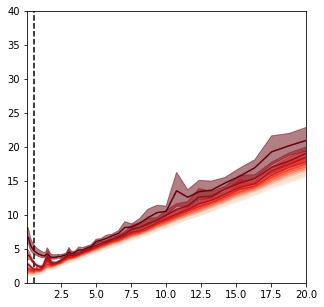

In [10]:
n_worms=7
plt.figure(figsize=(5,5))
n_modes_plot=10
colors_ = plt.cm.Reds_r(np.linspace(0,.9,n_modes_plot))
mean,cil,ciu=stats.bootstrap(ts_traj_w[:,:,0],median=False,n_times=1000)
# plt.text(2,35,r'$|1/\Lambda_2| = {:.12f}\pm({:.2f},{:.2f}) s$'.format(mean[11],cil[11],ciu[11]))
plt.axvline(delay_range[10]*dt,c='k',ls='--')
for mode in range(n_modes_plot):
    mean,cil,ciu=stats.bootstrap(ts_traj_w[:,:,mode],median=False,n_times=100)
    plt.plot(delay_range*dt,mean,c=colors_[mode])
    plt.fill_between(delay_range*dt,cil,ciu,alpha=.5,color=colors_[mode])

plt.xlim(dt,20)
plt.ylim(0,40)
# plt.savefig('tscales_Foraging_1000_clusters.pdf')
plt.show()


In [9]:
delay_range[13]*dt

0.7000000000000001

In [325]:
K_star=8
print(K_star*dt,11/16.)
traj_matrix = embed.trajectory_matrix(ma.vstack(tseries_w),K = K_star-1)

0.4 0.6875


In [326]:
import umap

def draw_umap(data,n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    return u

In [378]:
sel = ~np.any(traj_matrix.mask,axis=1)
u = np.zeros((traj_matrix.shape[0],2))
data = traj_matrix[sel]
n_neighbors=12
min_dist=0.05
u[sel] = draw_umap(data,n_neighbors=n_neighbors,min_dist=min_dist,metric='chebyshev')

In [379]:
u[~sel] = ma.masked

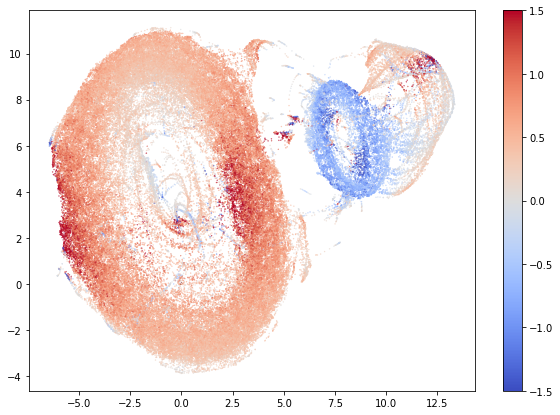

In [381]:
plt.figure(figsize=(10,7))
plt.scatter(u[:,0],u[:,1],c=omegas_all,vmax=1.5,vmin=-1.5,cmap='coolwarm',s=.1)
plt.colorbar()
plt.savefig('omegas_umap_npr1.png',dpi=300)
plt.show()

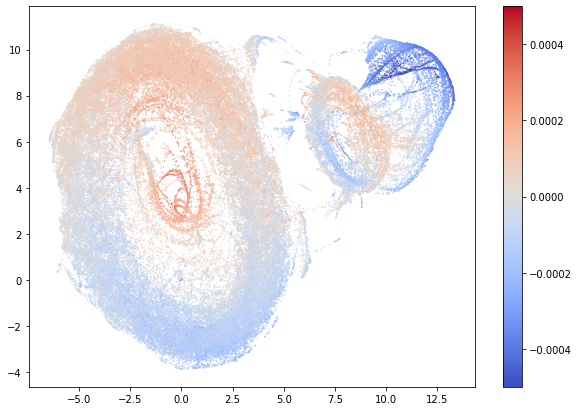

In [382]:
plt.figure(figsize=(10,7))
plt.scatter(u[:,0],u[:,1],c=thetas_sum,vmax=5e-4,vmin=-5e-4,cmap='coolwarm',s=.1)
plt.colorbar()
plt.savefig('theta_sums_umap_npr1.png',dpi=300)
plt.show()

In [331]:
traj_matrix.shape

(125887, 40)

In [332]:
N=562
labels = cl.kmeans_knn_partition(traj_matrix,n_seeds=N)

In [333]:
n_worms = len(tseries_w)
dt = 1/frameRate
delays_max = np.max([len(tseries_w[kw]) for kw in range(n_worms)])
delay_range = np.unique(np.array(np.logspace(0,np.log10(delays_max),100),dtype=int))
n_modes=10
tscales_w=ma.zeros((n_worms,len(delay_range),n_modes))
t0=0
for kw in range(n_worms):
    labels_here = labels[t0:t0+len(tseries_w[kw])].copy()
    sel = delay_range<len(labels_here)
    for kd in np.arange(len(delay_range))[sel]:
        delay = delay_range[kd]
        lcs,P = op_calc.transition_matrix(labels_here,delay,return_connected=True)
        final_labels = op_calc.get_connected_labels(labels_here,lcs)
        inv_measure = op_calc.stationary_distribution(P)
        R = op_calc.get_reversible_transition_matrix(P)
#         print(delay,R.shape)
        eigvals,eigvecs = op_calc.sorted_spectrum(R,k=n_modes+1)
        tscales_w[kw,kd] = -(delay*dt)/np.log(eigvals[1:].real)
    t0+=len(tseries_w[kw])
    print(kw)
# plt.plot(stats.acf(ctraj_w[0]))
# plt.plot()

0
1
2
3
4
5
6


In [334]:
tscales_w[tscales_w==0]=ma.masked

/apps/free81/python/3.7.3/lib/python3.7/site-packages/numpy-1.18.3-py3.7-linux-x86_64.egg/numpy/lib/nanfunctions.py:1372: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/apps/free81/python/3.7.3/lib/python3.7/site-packages/numpy-1.18.3-py3.7-linux-x86_64.egg/numpy/lib/nanfunctions.py:1372: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/apps/free81/python/3.7.3/lib/python3.7/site-packages/numpy-1.18.3-py3.7-linux-x86_64.egg/numpy/lib/nanfunctions.py:1372: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/apps/free81/python/3.7.3/lib/python3.7/site-packages/numpy-1.18.3-py3.7-linux-x86_64.egg/numpy/lib/nanfunctions.py:1372: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/apps/free81/python/3.7.3/lib/python3.7/site-packages/numpy-1.18.3-py3.7-linux-x86_64.egg/nu

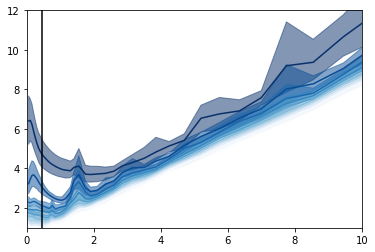

In [372]:
colors_mode = plt.cm.Blues_r(np.linspace(0,1,n_modes))
for km in range(n_modes):
    mean,cil,ciu=stats.bootstrap(tscales_w[:,:,km],n_times=100)
    plt.plot(delay_range*dt,mean,c=colors_mode[km])
    plt.fill_between(delay_range*dt,cil,ciu,alpha=.5,color=colors_mode[km])
# plt.xscale('log')
plt.xlim(0,10)
plt.ylim(1,12)
plt.axvline(9*dt,c='k')
# plt.axvline(20*dt,c='k')
plt.savefig('tscales_npr-1.pdf')
plt.show()

In [336]:
9*dt

0.45

In [337]:
delay=9
lcs,P = op_calc.transition_matrix(labels,delay,return_connected=True)
final_labels = op_calc.get_connected_labels(labels,lcs)
n_modes=10
inv_measure = op_calc.stationary_distribution(P)
R = op_calc.get_reversible_transition_matrix(P)
eigvals,eigvecs = op_calc.sorted_spectrum(R,k=n_modes)
sorted_indices = np.argsort(eigvals.real)[::-1]
eigvals = eigvals[sorted_indices][1:].real
eigvals[np.abs(eigvals-1)<1e-12] = np.nan
eigvals[eigvals<1e-12] = np.nan
eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
eigfunctions_traj[final_labels.mask] = ma.masked
phi2 = eigfunctions[:,1]

In [338]:
dt = 1/frameRate

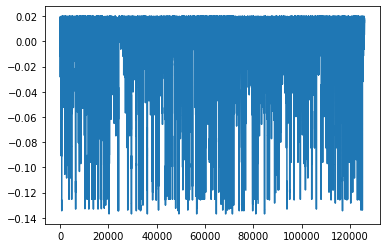

In [339]:
plt.plot(eigfunctions_traj[:,1])
plt.show()

In [340]:
thresh_range,rho_c,c_thresh,kmeans_labels = op_calc.optimal_partition(eigfunctions[:,1],inv_measure,P,return_rho=True)
phi2_traj = eigfunctions_traj[:,1]

In [341]:
sel = eigfunctions[:,1]<=c_thresh
c_negative = np.linspace(-2,0,sel.sum())
d_neg = {}
for k in range(c_negative.shape[0]):
    d_neg[np.sort(eigfunctions[sel,1])[k]] = c_negative[k]

sel = eigfunctions[:,1]>=c_thresh
c_positive = np.linspace(0,2,sel.sum())
d_pos = {}
for k in range(c_positive.shape[0]):
    d_pos[np.sort(eigfunctions[sel,1])[k]] = c_positive[k]
ctraj = ma.zeros(phi2_traj.shape[0])
sel = np.logical_and(phi2_traj<c_thresh,~phi2_traj.mask)
ctraj[sel] = np.array([d_neg[kc] for kc in phi2_traj[sel]])
sel = np.logical_and(phi2_traj>=c_thresh,~phi2_traj.mask)
ctraj[sel] = np.array([d_pos[kc] for kc in phi2_traj[sel]])
sel_mask = phi2_traj.mask
ctraj[sel_mask] = ma.masked


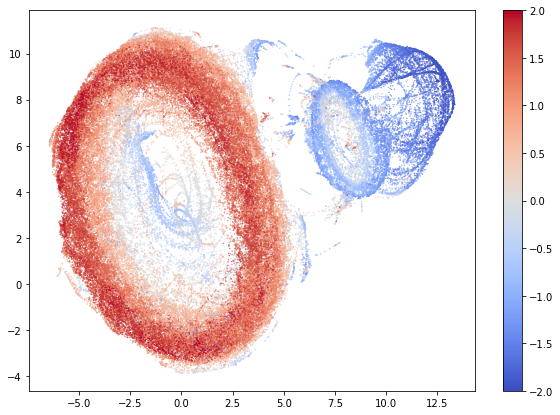

In [383]:
from matplotlib.colors import DivergingNorm
plt.figure(figsize=(10,7))
vmin,vmax=-2,2
plt.scatter(u[:,0],u[:,1],c=ctraj,norm=DivergingNorm(0,vmin=vmin,vmax=vmax),cmap='coolwarm',s=.1)
plt.colorbar()
plt.savefig('phi2_umap_npr1.png',dpi=300)
plt.show()

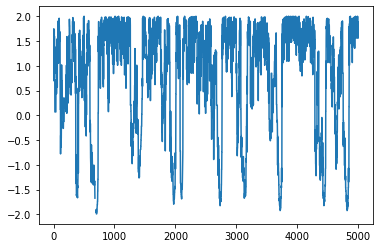

In [344]:
plt.plot(ctraj[:5000])
plt.show()

In [345]:
from lmfit import minimize, Parameters, Parameter, report_fit

def fit_tscales(x,y,b0=10,d0=50):
    
    def fcn2(params,x,data):
        a=params['a'].value
        b=params['b'].value
        c=params['c'].value
        d=params['d'].value
        #Fits the drift

        return (a*np.exp(-x/b) + c * np.exp(-x/d) - data)

    params = Parameters()
    params.add('a',   value= 1)
    params.add('b', value= b0,min=0)
    params.add('c', value= 1)
    params.add('d', value= d0,min=0)

    # do fit, here with leastsq model
    result = minimize(fcn2, params, args=(x,y))
    
    p1 = result.params['a'].value
    p2 = result.params['b'].value
    p3 = result.params['c'].value
    p4 = result.params['d'].value
    tscales = np.array([p2,p4])
    stderrs = np.array([result.params['b'].stderr,result.params['d'].stderr])
    
    return p1,p2,p3,p4,tscales,stderrs

def func2(x, a, b, c, d):
    return a * np.exp(-x/b) + c * np.exp(-x/d) 

In [346]:
def state_lifetime(states):
    durations=[]
    for state in np.sort(np.unique(states.compressed())):
        gaps = states==state
        gaps_boundaries = np.where(np.abs(np.diff(np.concatenate([[False], gaps, [False]]))))[0].reshape(-1, 2)
        durations.append(np.hstack(np.diff(gaps_boundaries)))
    return durations

In [347]:
n_worms = len(tseries_w)
cluster_traj = ma.copy(final_labels)
cluster_traj[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj[final_labels.mask] = ma.masked
cluster_traj_w = []
ctraj_w = []
t0 = 0
for kw in range(n_worms):
    cluster_traj_w.append(cluster_traj[t0:t0+len(tseries_w[kw])])
    ctraj_w.append(ctraj[t0:t0+len(tseries_w[kw])])
    t0+=len(tseries_w[kw])

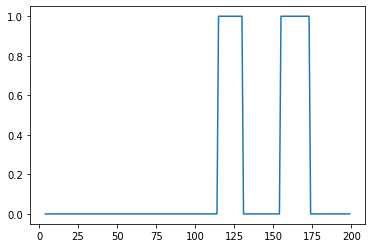

In [348]:
plt.plot(cluster_traj_w[0][:200])
plt.show()

In [349]:
# stride=int(delay/2)

In [350]:
# stride=1
# dts_state = []
# for state in range(2):
#     gaps = cluster_traj[::stride]==state
#     gaps_boundaries = np.where(np.abs(np.diff(np.concatenate([[False], gaps, [False]]))))[0].reshape(-1, 2)
#     dts = np.hstack(np.diff(gaps_boundaries,axis=1))
#     dts_state.append(dts)

In [351]:
# plt.hist(np.hstack(dts_state)*dt*stride,bins=100)
# plt.yscale('log')
# plt.show()

# plt.hist(np.hstack(dts_state[0])*dt*stride,bins=100)
# plt.yscale('log')
# plt.show()

# plt.hist(np.hstack(dts_state[1])*dt*stride,bins=100)
# plt.yscale('log')
# plt.show()

In [352]:
stride = int(delay/2)
# stride=1
dts_w=[]
for kw,labels_here in enumerate(cluster_traj_w):
    dts = np.hstack(state_lifetime(labels_here[::stride]))*dt*stride
    dts_w.append(dts)

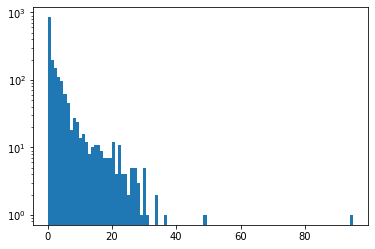

In [353]:
plt.hist(np.hstack(dts_w),bins=100)
plt.yscale('log')
plt.show()

In [354]:
def get_errorbar_dist(lifetimes_w,t0,tf):
    all_lt = np.hstack(lifetimes_w)
    x,y = stats.complementary_cumulative_dist(all_lt,(t0,tf))
    y_all = np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
    x_all = np.sort(np.unique(x))
    
    dict_y = {}
    for x_ in x_all:
        dict_y[x_] = []

    for k in range(100):
        x,y = stats.cumulative_dist(np.hstack(np.random.choice(lifetimes_w,len(lifetimes_w))),(t0,tf))
        y = 1-np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
        x = np.sort(np.unique(x))
        for kx in range(len(y)):
            dict_y[x[kx]].append(y[kx])
        if k%10==0:
            print(k)
            
    y_errorbars = np.zeros((len(dict_y.keys()),3))
    for kx,x_ in enumerate(x_all):
        values = np.array(dict_y[x_])
        values = values[values>0]
        cil = np.percentile(values,2.5)
        ciu = np.percentile(values,97.5)
        y_errorbars[kx] = [y_all[kx],cil,ciu]
    return x_all,y_errorbars

In [355]:
t0,tf = 0,5000
# t0,tf = 0,1000
all_lt = np.hstack(dts_w)
x,y = stats.complementary_cumulative_dist(all_lt,(t0,tf))
y_all = np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
x_all = np.sort(np.unique(x))

p1,p2,p3,p4,tscales,stderrs = fit_tscales(x_all,y_all,b0=.5,d0=10)
params_all = np.array([p1,p2,p3,p4])
sorted_indices = np.argsort(tscales)[::-1]
tscales_all = tscales[sorted_indices]

dict_y = {}
for x_ in x_all:
    dict_y[x_] = []

In [356]:
tscales_bootstrap = []
params_bootstrap = []
rates_bootstrap = []
for k in range(1000):
    x,y = stats.complementary_cumulative_dist(np.hstack(np.random.choice(dts_w,len(dts_w))),(t0,tf))
    y = np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
    x = np.sort(np.unique(x))
    p1,p2,p3,p4,tscales,stderrs = fit_tscales(x,y,b0=1,d0=25)
    params_bootstrap.append(np.array([p1,p2,p3,p4]))
    sorted_indices = np.argsort(tscales)[::-1]
    tscales = tscales[sorted_indices]
    tscales_bootstrap.append(tscales)
    rates_bootstrap.append((1/tscales).sum())
    for kx in range(len(y)):
        dict_y[x[kx]].append(y[kx])

In [357]:
y_errorbars = np.zeros((len(dict_y.keys()),3))
for kx,x_ in enumerate(x_all):
    values = np.array(dict_y[x_])
    values = values[values>0]
    cil = np.percentile(values,2.5)
    ciu = np.percentile(values,97.5)
    y_errorbars[kx] = [y_all[kx],cil,ciu]

In [358]:
tscales_cil = np.percentile(np.vstack(tscales_bootstrap),2.5,axis=0)
tscales_ciu = np.percentile(np.vstack(tscales_bootstrap),97.5,axis=0)

rates_cil = np.percentile(np.vstack(rates_bootstrap),2.5,axis=0)
rates_ciu = np.percentile(np.vstack(rates_bootstrap),97.5,axis=0)

params_cil = np.percentile(params_bootstrap,2.5,axis=0)
params_ciu = np.percentile(params_bootstrap,97.5,axis=0)

p1,p2,p3,p4 = params_all
curvey = func2(x_all,p1,p2,p3,p4)

p1,p2,p3,p4 = params_cil
curvey_cil = func2(x_all,p1,p2,p3,p4)

p1,p2,p3,p4 = params_ciu
curvey_ciu = func2(x_all,p1,p2,p3,p4)

In [359]:
lambda_rec = 1/(1/tscales_all[0]+1/tscales_all[1])
lambda_rec_cil = np.percentile(1/np.sum(1/np.vstack(tscales_bootstrap),axis=1),2.5)
lambda_rec_ciu = np.percentile(1/np.sum(1/np.vstack(tscales_bootstrap),axis=1),97.5)

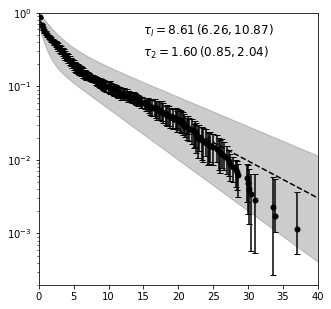

In [374]:
plt.figure(figsize=(5,5))
plt.errorbar(x_all,y_errorbars[:,0],yerr = [y_errorbars[:,0]-y_errorbars[:,1],y_errorbars[:,2]-y_errorbars[:,0]],fmt='o',ms=5,capsize=3,c='k')
plt.plot(x_all,curvey,c='k',ls='--')
plt.fill_between(x_all,curvey_cil,curvey_ciu,color='k',alpha=.2)
plt.ylim(2e-4,1)
plt.yscale('log')
plt.xlim(0,40)
plt.text(15,.5,r'$\tau_l = {:.2f}\,({:.2f},{:.2f})$'.format(tscales_all[0],tscales_cil[0],tscales_ciu[0]),fontsize=12)
plt.text(15,.25,r'$\tau_2 = {:.2f}\,({:.2f},{:.2f})$'.format(tscales_all[1],tscales_cil[1],tscales_ciu[1]),fontsize=12)
# plt.text(30,.1,.r'$1/\Lambda = {:.2f}\,({:.2f},{:.2f})$'.format(lambda_rec,lambda_rec_cil,lambda_rec_ciu),fontsize=12)
plt.savefig('dwell_times_npr-1_{}_{}_delay_{}_with_errorbars.pdf'.format(t0,tf,delay))
plt.show()

In [361]:
lags_max = np.max([len(ctraj_w[kw]) for kw in range(n_worms)])
lags = np.unique(np.array(np.logspace(0,np.log10(lags_max),5000),dtype=int))
C_w=ma.zeros((n_worms,len(lags)))
for kw in range(n_worms):
    sel = lags<len(ctraj_w[kw])
    C_est = ma.zeros(len(lags))
    C_est[sel] = stats.acf(ctraj_w[kw],lags[sel])
    C_est[~sel] = ma.masked
    C_w[kw] = C_est
# plt.plot(stats.acf(ctraj_w[0]))
# plt.plot()

In [362]:
C_w = ma.masked_invalid(C_w)
C_w[C_w==0] = ma.masked

In [363]:
mean,cil,ciu=stats.bootstrap(C_w,n_times=100)

/apps/free81/python/3.7.3/lib/python3.7/site-packages/numpy-1.18.3-py3.7-linux-x86_64.egg/numpy/lib/nanfunctions.py:1372: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


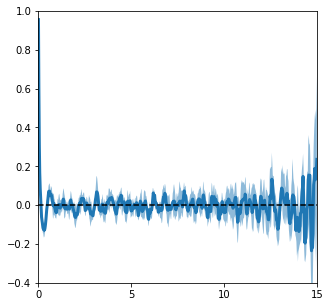

In [364]:
plt.figure(figsize=(5,5))
plt.plot(lags*dt/60,mean,lw=3)
plt.fill_between(lags*dt/60,cil,ciu,alpha=.5)
plt.axhline(0,ls='--',c='k')
# plt.xlim(0,1.5)
plt.xticks(np.arange(0,16,5))
plt.xlim(0,15)
plt.ylim(-.4,1)
plt.savefig('acf_npr-1_all.pdf')
plt.show()


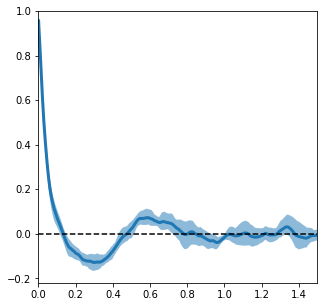

In [365]:
plt.figure(figsize=(5,5))
plt.plot(lags*dt/60,mean,lw=3)
plt.fill_between(lags*dt/60,cil,ciu,alpha=.5)
plt.axhline(0,ls='--',c='k')
plt.xlim(0,1.5)
plt.ylim(-.22,1)
plt.savefig('acf_npr-1_zoomin.pdf')
plt.show()

#  pirouette rate time

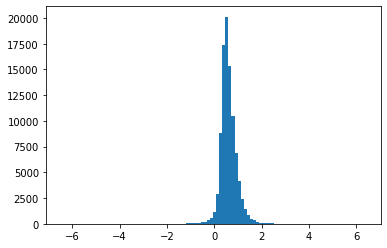

In [366]:
plt.hist(omegas_all[cluster_traj==0],bins=100)
plt.show()

In [367]:
wsize = int(3*60*frameRate)

In [368]:
cluster_traj_w = []
t0=0
for kw in range(len(tseries_w)):
    cluster_traj_w.append(cluster_traj[t0:t0+len(tseries_w[kw])])
    t0+=len(tseries_w[kw])

In [369]:
window_t0s = np.arange(0,len(cluster_traj_w[kw]),wsize) 
pir_rate_w=np.zeros((len(tseries_w),5))
run_rate_w = np.zeros((len(tseries_w),5))
for kw in range(len(tseries_w)):
    pir_rate_w[kw] = [np.sum(cluster_traj_w[kw][t0:t0+wsize]==0)/(ma.count(cluster_traj_w[kw][t0:t0+wsize])) for t0 in window_t0s]

    run_rate_w[kw] = [np.sum(cluster_traj_w[kw][t0:t0+wsize]==1)/(ma.count(cluster_traj_w[kw][t0:t0+wsize])) for t0 in window_t0s]

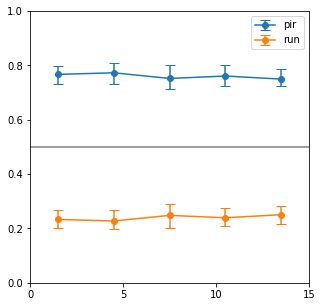

In [370]:
plt.figure(figsize=(5,5))
mean,cil,ciu = stats.bootstrap(pir_rate_w,n_times=100)
plt.errorbar((window_t0s+wsize/2)/(frameRate*60),mean,yerr = [mean-cil,ciu-mean],capsize=5,marker='o',label='pir')
mean,cil,ciu = stats.bootstrap(run_rate_w,n_times=100)
plt.errorbar((window_t0s+wsize/2)/(frameRate*60),mean,yerr = [mean-cil,ciu-mean],capsize=5,marker='o',label='run')
# plt.ylim(6,14)
plt.legend()
plt.xlim(0,15)
plt.xticks(np.arange(0,16,5))
plt.axhline(0.5,c='gray')

plt.ylim(0,1)
plt.savefig('p_states.pdf')
plt.show()